# Imports

In [14]:
import torch
import sys
print(sys.executable)
import albumentations as A
import tensorflow as tf
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50
from PIL import Image
import tensorflow_hub as hub
import torch.nn.functional as F
from torch.optim import Adam

import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import class_weight
import os
import glob
from tqdm import tqdm
from FinalModels.ESRGAN.model import ESRGAN

project_root = os.path.abspath(os.path.join(os.getcwd()))



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



folder_path = "d:\\workspace\\ThesisProject\\TESTS\\images\\LR"

print("Current device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print(f"Using device: {torch.device("cuda" if torch.cuda.is_available() else "cpu")}")


esrgan_model = ESRGAN(model_path='./FinalModels/ESRGAN/model/RRDB_PSNR_x4.pth', device=device)

d:\workspace\ThesisProject\venv\Scripts\python.exe
Current device: NVIDIA GeForce GTX 1050 Ti
Using device: cuda


# FUNCTIONS

In [17]:
def preprocess_image_esrgan(image_path, device):
    """Loads an image from a path, converts it to RGB, and preprocesses it for the model."""
    img = Image.open(image_path).convert("RGB")
    transform = transforms.ToTensor()  
    img = transform(img).unsqueeze(0).to(device)  
    return img

def enhance_image(image_path, model, device):
    """Enhances an image using the ESRGAN model."""
    # Preprocess the image
    # start = time.time()
    img = preprocess_image_esrgan(image_path, device)
    
    # Resize the image once before feeding to the model (if needed)
    resized_img = F.interpolate(img, size=(224, 224), mode='bicubic', align_corners=False)

    # Perform super-resolution
    with torch.no_grad():
        sr_image = model(resized_img)
    
    # print("Images shape: ", "Original:", img.shape, "SR:", sr_image.shape)
    # print("Time Taken: %f seconds" % (time.time() - start))
    
    return img, sr_image  # Return both original and enhanced images


def downscale_image(image, scale_factor=4):
    """Scales down images using bicubic downsampling."""
    _, _, h, w = image.shape
    new_h, new_w = h // scale_factor, w // scale_factor
    image = F.interpolate(image, size=(new_h, new_w), mode='bicubic', align_corners=False)
    return image

def evaluate_performance(hr_image, sr_image):
    """Evaluates the performance of the super-resolved image using PSNR."""
    print("Shape before eval hr:", hr_image.shape)
    print("Shape before eval sr:", sr_image.shape)
    
    sr_image = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bilinear', align_corners=False)

    print("final Shape hr:", hr_image.shape)
    print("final Shape sr:", sr_image.shape)

    if hr_image.shape != sr_image.shape:
        print(f"Shape mismatch: HR {hr_image.shape}, SR {sr_image.shape}")
        return None  

    mse = F.mse_loss(sr_image, hr_image)
    
    if mse == 0:
        print("PSNR: Infinite (identical images)")
        return float('inf')  
    
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))

    print("=============PSNR Achieved: %f==============" % psnr.item())
    return psnr


def compare_images(hr_image, lr_image, sr_image, psnr):
    """Compare the images by displaying them and printing PSNR."""
    sr_image = F.interpolate(sr_image, size=hr_image.shape[2:], mode='bicubic', align_corners=False)

    def process_image(img):
        """Convert PyTorch tensor to NumPy array with correct shape."""
        if isinstance(img, torch.Tensor):
            img = img.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert (3, H, W) to (H, W, 3)
        else:
            img = np.squeeze(img)  # If already NumPy, just squeeze
            if img.ndim == 3 and img.shape[0] in [1, 3]:  # If channel-first, convert to channel-last
                img = np.transpose(img, (1, 2, 0))
        return img


    hr_image = hr_image.cpu().numpy() if isinstance(hr_image, torch.Tensor) else hr_image
    lr_image = lr_image.cpu().numpy() if isinstance(lr_image, torch.Tensor) else lr_image
    sr_image = sr_image.cpu().numpy() if isinstance(sr_image, torch.Tensor) else sr_image
    
    hr_image = np.clip(hr_image, 0, 1)
    lr_image = np.clip(lr_image, 0, 1)
    sr_image = np.clip(sr_image, 0, 1)

    hr_image = process_image(hr_image)
    lr_image = process_image(lr_image)
    sr_image = process_image(sr_image)

    print("Evaluation Images shape:", hr_image.shape, lr_image.shape, sr_image.shape)

    plt.rcParams['figure.figsize'] = [15, 10]
    fig, axes = plt.subplots(1, 3)
    fig.tight_layout()

    plt.subplot(131)
    plot_image(hr_image, title="Original")
    
    plt.subplot(132)
    plot_image(lr_image, title="x4 Bicubic")
    
    plt.subplot(133)
    plot_image(sr_image, title="Super Resolution")
    
    plt.show(block=False)

def save_image_esrgan(image, save_path, device, filename, size=224):
    """Saves the image tensor to a file after interpolation and conversion, running on GPU if needed."""
    
    # Ensure image is on the specified device (GPU or CPU)
    image = image.to(device)
    # print("Shape before interpolate:", image.shape)
    
    # Perform bicubic interpolation to the specified size
    image = F.interpolate(image, (size, size), mode='bicubic', align_corners=False).squeeze(0)
    
    # Convert from (C, H, W) to (H, W, C)
    image = image.squeeze().permute(1, 2, 0)
    
    # Move tensor to CPU before converting to NumPy
    image = image.cpu().numpy()
    
    # Rescale image values to [0, 255] and ensure they are uint8
    image = np.clip(image * 255, 0, 255).astype(np.uint8)
    
    print("Shape before save:", image.shape)
    
    # Convert to a PIL image and save
    pil_image = Image.fromarray(image)
    try:
        pil_image.save(os.path.join(save_path, filename + '.png'), format='PNG')  # Ensure .png extension
        print(f"Saved {filename} at {save_path}")
    except Exception as e:
        print(f"Error saving {filename}: {e}")
    
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)


def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)


def pad_to_square(image):
    # Get original dimensions
    old_h, old_w = image.shape[:2]
    
    # Find the larger dimension to make the image square
    max_dim = max(old_h, old_w)
    
    # Calculate padding
    pad_h = (max_dim - old_h) // 2
    pad_w = (max_dim - old_w) // 2
    
    # Ensure padding is non-negative and compatible
    padded_image = tf.image.pad_to_bounding_box(image, pad_h, pad_w, max_dim, max_dim)
    
    # Handle any excess due to rounding differences
    padded_image = tf.image.resize_with_crop_or_pad(padded_image, max_dim, max_dim)
    
    return padded_image

def get_image_index(file_name, image_dir="./data/DATASET/TRAIN_UNET/enhanced_images/*.jpg"):
    """
    Retrieves the index of an image file name in the list of loaded images.
    
    Args:
        file_name (str): The file name of the image (e.g., 'image1.jpg').
        image_dir (str): The directory path of the images.

    Returns:
        int: The index of the image in the list of images, or -1 if not found.
    """
    for idx, img_path in enumerate(glob.glob(image_dir)):
        if file_name in img_path:
            return idx
    return -1

def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

def plot_image_tensor(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

def train_model_unet(model, dataloader, val_dataloader, optimizer, criterion, epochs, device):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        running_iou = 0.0  # IoU accumulator for training

        # Create a tqdm progress bar for the dataloader
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", ncols=100, unit="batch")

        for batch in progress_bar:
            # Access image and mask from the batch (batch is a tuple)
            inputs, labels = batch  # Unpack the tuple into inputs and labels
            
            # Move the tensors to the appropriate device (e.g., GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: Make predictions by passing the inputs through the model
            optimizer.zero_grad()  # Clear gradients from the previous step
            outputs = model(inputs)  # Pass inputs through the model
            loss = criterion(outputs, labels)  # Calculate loss

            # Backward pass: Compute gradients and update model weights
            loss.backward()  # Backpropagate the error
            optimizer.step()  # Update weights using optimizer

            # Accumulate loss and IoU for this batch
            running_loss += loss.item()
            outputs = outputs.detach().cpu().numpy()  # Detach outputs and move to CPU
            labels = labels.detach().cpu().numpy()  # Detach labels and move to CPU
            iou = compute_iou(outputs, labels)  # IoU calculation
            running_iou += iou

        # Calculate training loss and IoU for the current epoch
        train_loss = running_loss / len(dataloader)
        train_iou = running_iou / len(dataloader)

        # Evaluate the model on the validation set
        val_loss, val_iou = evaluate_model_unet(model, val_dataloader, criterion, device)

        # Save metrics for this epoch
        train_losses.append(train_loss)
        train_ious.append(train_iou)
        val_losses.append(val_loss)
        val_ious.append(val_iou)

        # Print metrics for this epoch
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss={train_loss:.4f}, Train IoU={train_iou:.4f}, "
              f"Val Loss={val_loss:.4f}, Val IoU={val_iou:.4f}")

    # Return the history for further processing (such as saving or plotting)
    history = {
        'epoch': range(1, epochs + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_iou': train_ious,
        'val_iou': val_ious
    }

    return history  # Return the history dictionary



def compute_iou(preds, labels, threshold=0.5, num_classes=2):
    # preds are probabilities (not logits), threshold them to get binary masks
    preds = (preds > threshold).astype(int)  # Binary thresholding
    
    ious = []
    for i in range(num_classes):  # For each class (0 and 1 for binary segmentation)
        intersection = np.sum((preds == i) & (labels == i))
        union = np.sum((preds == i) | (labels == i))
        iou = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero
        ious.append(iou)

    return np.mean(ious)

@torch.no_grad()
def evaluate_model_unet(model, val_dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    running_iou = 0.0  # IoU accumulator for validation
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients for validation
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            # outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()

            # For binary segmentation, apply sigmoid and threshold to get binary predictions
            preds = (outputs > 0.5).cpu().numpy()  # Apply threshold for binary classification
            
            # Compute IoU for this batch
            iou = compute_iou(preds, labels.cpu().numpy())
            running_iou += iou

            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    # Calculate mean IoU for the entire validation set
    mean_iou = running_iou / len(val_dataloader)

    # Return the validation loss and mean IoU
    return val_loss / len(val_dataloader), mean_iou


# Training and evaluation loop
def train_model(model, dataloader, val_dataloader, optimizer, criterion, epochs, device):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Create a tqdm progress bar for the dataloader
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", ncols=100, unit="batch")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)

        # Calculate training accuracy
        train_loss = running_loss / len(dataloader)
        train_acc = correct / total

        # Evaluate on the validation set
        val_acc, val_loss = evaluate_model(model, val_dataloader, criterion)

        # Save metrics for this epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Return the history for further processing (such as saving or plotting)
    history = {
        'epoch': range(1, epochs + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    return history  # Return the history dictionary


# Evaluation loop
def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    return val_acc, val_loss / len(dataloader)

def test_model(model, test_dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Define the function for predicting and measuring speed
def predict_image(model, image_path, device, class_labels):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ResNet's requirements
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model
    image = image.to(device)

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        outputs = model(image)

    # Calculate prediction probabilities using softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Get the predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    prediction_time = time.time() - start_time

    return predicted_class, prediction_time, probabilities[0]  # Return class, time, and probabilities

def predict_image_with_debug(model, image_path, device, class_labels):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)
    # image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert tensor to NumPy array (H, W, C)
    # image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # De-normalize
    # image = (image * 255).astype(np.uint8)  # Convert to 8-bit image

    # Start time for inference
    start_time = time.time()

    # Perform inference
    model.eval()
    with torch.no_grad():
        logits = model(image)  # Raw logits from the model

    # Calculate probabilities using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Plot class probabilities
    plt.bar(range(len(class_labels)), probabilities[0].cpu().numpy())
    plt.xticks(range(len(class_labels)), class_labels, rotation=90)
    plt.show()

    # Get predicted class and its probability
    predicted_class_index = probabilities.argmax().item()
    predicted_class = class_labels[predicted_class_index]
    confidence = probabilities.max().item()
    prediction_time = time.time() - start_time

    return predicted_class, confidence, prediction_time

def plot_from_history(history):
    # Extract data from the history dictionary
    epochs = len(history['epoch'])
    train_losses = history['train_loss']
    val_losses = history['val_loss']
    train_accuracies = history['train_accuracy']
    val_accuracies = history['val_accuracy']

    # Plot the metrics
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Save the plot
    plt.tight_layout()
    plt.savefig('training_history.png')  # Save the plot as a PNG image
    plt.show()
    
def get_class_labels(dataset_dir):
    # Get all folder names in the directory, which are your class labels
    class_labels = sorted(os.listdir(dataset_dir))  # Assuming each subfolder is a class
    return class_labels

# Dataset Preparation

In [20]:
train_dir = './DATASET/TRAIN'
enhancedtrain_dir = './DATASET/TRAIN_ESRGAN2_UNET'
test_dir = './DATASET/TEST'
enhancedtest_dir = './DATASET/TEST_ESRGAN2_UNET'
val_dir = './DATASET/VALIDATION'
enhancedval_dir = './DATASET/VALIDATION_ESRGAN2_UNET'

seed = 42
np.random.seed(seed)
random.seed(seed)


In [64]:


# Hyperparameters
img_height, img_width = 224, 224
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  


# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width), interpolation=Image.BICUBIC),
    # transforms.RandomRotation(90),
    # transforms.ColorJitter(brightness=(0.8, 1.2)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomResizedCrop((img_height, img_width), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


val_test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=val_test_transform) # train transform for augmented
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Enhanced datasets
enhanced_train_dataset = datasets.ImageFolder(enhancedtrain_dir, transform=train_transform) # train transform for augmented
enhanced_val_dataset = datasets.ImageFolder(enhancedval_dir, transform=val_test_transform)
enhanced_test_dataset = datasets.ImageFolder(enhancedtest_dir, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
enhanced_val_loader = DataLoader(enhanced_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
enhanced_test_loader = DataLoader(enhanced_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Number of images in training set: {len(train_dataset)}")
print(f"Number of images in validation set: {len(val_dataset)}")
print(f"Number of images in test set: {len(test_dataset)}")

print(f"Number of images in enhanced training set: {len(enhanced_train_dataset)}")
print(f"Number of images in enhanced validation set: {len(enhanced_val_dataset)}")
print(f"Number of images in enhanced test set: {len(enhanced_test_dataset)}")


Number of images in training set: 1679
Number of images in validation set: 474
Number of images in test set: 246
Number of images in enhanced training set: 1679
Number of images in enhanced validation set: 474
Number of images in enhanced test set: 246


# PYTORCH (BASELINE)

In [65]:
learning_rate = 0.001
epochs = 5


torch_baseline = resnet50(weights="IMAGENET1K_V1")
torch_baseline = torch_baseline.to(device)


# freeze = True
# for name, layer in torch_baseline.named_modules():
#     # Explicitly freeze all layers up to layer3
#     if 'layer4' in name:
#         freeze = False  # Start unfreezing at layer3
#     if freeze:
#         for param in layer.parameters():
#             param.requires_grad = False
#     else:
#         for param in layer.parameters():
#             param.requires_grad = True


# FREEZE ALL LAYERS
for name, layer in torch_baseline.named_modules():
    for param in layer.parameters():
        param.requires_grad = False


class BaselineResNet(nn.Module):
    def __init__(self, base_model, num_classes=18):
        super(BaselineResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)
        gap = self.gap(x).view(x.size(0), -1)
        x = self.fc(gap)
        return x


torch_baseline_model = BaselineResNet(torch_baseline).to(device)

learning_rate = .001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, torch_baseline_model.parameters()), lr=learning_rate)


for name, layer in torch_baseline.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')


: False
conv1: False
bn1: False
relu: False
maxpool: False
layer1: False
layer1.0: False
layer1.0.conv1: False
layer1.0.bn1: False
layer1.0.conv2: False
layer1.0.bn2: False
layer1.0.conv3: False
layer1.0.bn3: False
layer1.0.relu: False
layer1.0.downsample: False
layer1.0.downsample.0: False
layer1.0.downsample.1: False
layer1.1: False
layer1.1.conv1: False
layer1.1.bn1: False
layer1.1.conv2: False
layer1.1.bn2: False
layer1.1.conv3: False
layer1.1.bn3: False
layer1.1.relu: False
layer1.2: False
layer1.2.conv1: False
layer1.2.bn1: False
layer1.2.conv2: False
layer1.2.bn2: False
layer1.2.conv3: False
layer1.2.bn3: False
layer1.2.relu: False
layer2: False
layer2.0: False
layer2.0.conv1: False
layer2.0.bn1: False
layer2.0.conv2: False
layer2.0.bn2: False
layer2.0.conv3: False
layer2.0.bn3: False
layer2.0.relu: False
layer2.0.downsample: False
layer2.0.downsample.0: False
layer2.0.downsample.1: False
layer2.1: False
layer2.1.conv1: False
layer2.1.bn1: False
layer2.1.conv2: False
layer2.1.bn

In [66]:
baseline_history = train_model(torch_baseline_model, train_loader, val_loader, optimizer, criterion, epochs=epochs, device=device)

Epoch 1/5: 100%|████████████████████| 53/53 [00:28<00:00,  1.89batch/s, accuracy=0.487, loss=0.0619]


Epoch 1/5: Train Loss=1.9598, Train Acc=0.4872, Val Loss=1.4725, Val Acc=0.6814


Epoch 2/5: 100%|████████████████████| 53/53 [00:27<00:00,  1.92batch/s, accuracy=0.739, loss=0.0382]


Epoch 2/5: Train Loss=1.2091, Train Acc=0.7391, Val Loss=1.0791, Val Acc=0.7384


Epoch 3/5: 100%|████████████████████| 53/53 [00:27<00:00,  1.90batch/s, accuracy=0.799, loss=0.0292]


Epoch 3/5: Train Loss=0.9256, Train Acc=0.7993, Val Loss=0.8727, Val Acc=0.7932


Epoch 4/5: 100%|████████████████████| 53/53 [00:27<00:00,  1.90batch/s, accuracy=0.825, loss=0.0244]


Epoch 4/5: Train Loss=0.7743, Train Acc=0.8249, Val Loss=0.7638, Val Acc=0.8333


Epoch 5/5: 100%|████████████████████| 53/53 [00:28<00:00,  1.87batch/s, accuracy=0.869, loss=0.0205]


Epoch 5/5: Train Loss=0.6483, Train Acc=0.8690, Val Loss=0.6867, Val Acc=0.8249


In [68]:
# Test model and evaluate performance
y_true, y_pred = test_model(torch_baseline_model, test_loader)

print("\nClassification Report:")

class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.88      0.64      0.74        11
 Acanthurus Nigrofuscus       0.47      0.86      0.61        21
   Balistapus Undulatus       1.00      0.20      0.33         5
 Canthigaster Valentini       0.93      0.93      0.93        14
 Chaetodon Trifascialis       0.60      0.95      0.73        19
   Hemigymnus Fasciatus       0.83      0.83      0.83        24
  Hemigymnus Melapterus       1.00      0.40      0.57         5
        Lutjanus fulvus       1.00      1.00      1.00        20
     Myripristis Kuntee       0.85      0.98      0.91        45
Neoglyphidodon Nigroris       0.00      0.00      0.00         3
      Neoniphon Sammara       0.93      0.97      0.95        29
 Pempheris Vanicolensis       0.00      0.00      0.00         4
Pomacentrus Moluccensis       0.95      1.00      0.97        18
               Scaridae       1.00      0.17      0.29         6


d:\workspace\ThesisProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\workspace\ThesisProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\workspace\ThesisProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\workspace\Thesis

['Abudefduf Vaigiensis', 'Acanthurus Nigrofuscus', 'Balistapus Undulatus', 'Canthigaster Valentini', 'Chaetodon Trifascialis', 'Hemigymnus Fasciatus', 'Hemigymnus Melapterus', 'Lutjanus fulvus', 'Myripristis Kuntee', 'Neoglyphidodon Nigroris', 'Neoniphon Sammara', 'Pempheris Vanicolensis', 'Pomacentrus Moluccensis', 'Scaridae', 'Scolopsis Bilineata', 'Siganus Fuscescens', 'Zanclus Cornutus', 'Zebrasoma Scopas']
Logits: tensor([[-3.2724, -1.4589, -3.1128, -2.6746, -1.4504, -1.7530, -2.3411, -2.3090,
         -1.2983, -3.0764, -1.9754, -1.9210, -0.5747, -2.5510, -2.9525, -3.5631,
         -2.1959, -2.3216]], device='cuda:0')


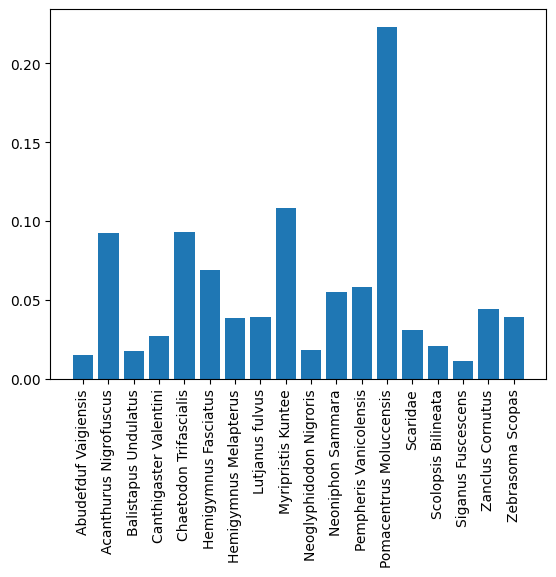

Predicted Class: Pomacentrus Moluccensis
Confidence: 22.32%
Inference Time: 0.1945 seconds


In [75]:
class_labels = train_dataset.classes
print(class_labels)


image_path = "./data/DATASET/TEST/Lutjanus fulvus/fish_000000819594_03407.png"

random_path = './sample_images/SAMPLE_LUTJANUS.jpg'
predicted_class, confidence, prediction_time = predict_image_with_debug(torch_baseline_model, random_path, device, class_labels)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence * 100:.2f}%") 
print(f"Inference Time: {prediction_time:.4f} seconds")


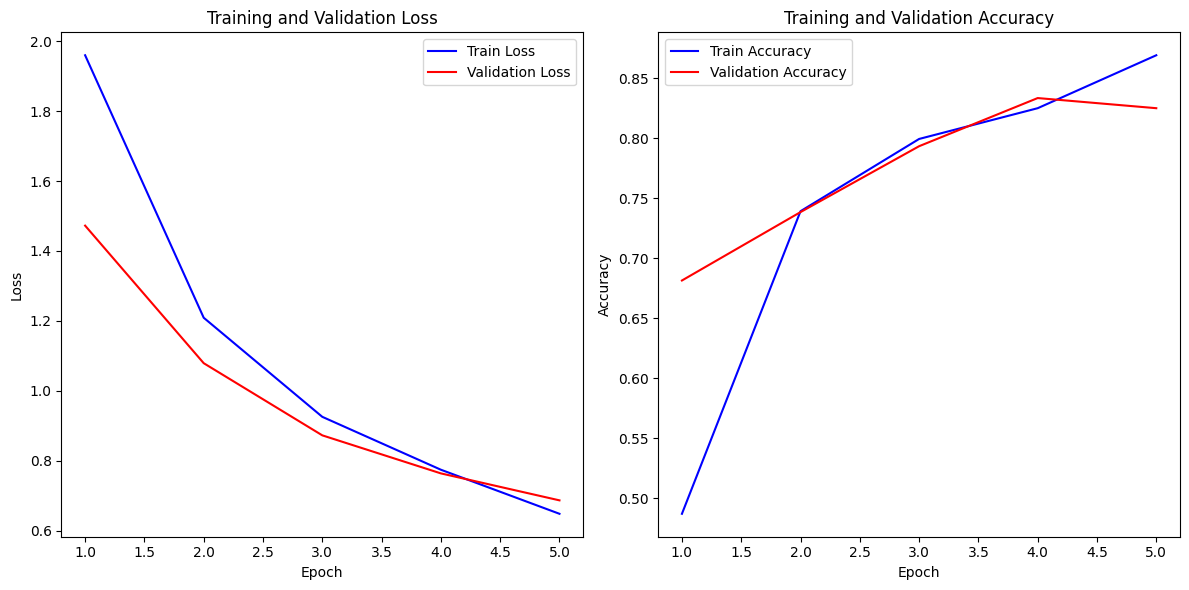

In [69]:
plot_from_history(baseline_history)

**VIEW HISTORY FROM A FILE** 

In [ ]:

history_df = pd.read_csv('training_history.csv') #filename
history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}

# Plot the history
plot_from_history(history)

**Save Model - MAKE FILENAME MEANINGFUL**

In [70]:

df = pd.DataFrame(baseline_history)
# HISTORY OR GRAPH
df.to_csv('./saved_models/history/torch_history_baselineb32notauglr001notenhancedvallacc82testacc80traintime3m_2ssepoch5ratio70_20_10epoch5.csv', index=False)

# MODEL
torch.save(torch_baseline_model, './saved_models/model/torch_baselineb32notauglr001notenhancedvallacc82testacc80traintime3m_2sepoch5ratio70_20_10epoch5.pth')

#WEIGHTS
torch.save(torch_baseline_model.state_dict(), './saved_models/weights/torch_weights_baselineb32notauglr001notenhancedvallacc86testacc80traintime3m_2ssepoch5ratio70_20_10epoch5.pth')

# PYTORCH (PROPOSED)

In [50]:
learning_rate = 0.001
epochs = 5


torch_proposed = resnet50(weights="IMAGENET1K_V1")
torch_proposed = torch_proposed.to(device)

# Freeze the initial 39 layers
# freeze = True
# for name, layer in torch_proposed.named_modules():
#     # Explicitly freeze all layers up to layer3
#     if 'layer4' in name:
#         freeze = False  # Start unfreezing at layer3
#     if freeze:
#         for param in layer.parameters():
#             param.requires_grad = False
#     else:
#         for param in layer.parameters():
#             param.requires_grad = True

# FREEZE ALL LAYERS
for name, layer in torch_proposed.named_modules():
    for param in layer.parameters():
        param.requires_grad = False


class ProposedResNet(nn.Module):
    def __init__(self, base_model, num_classes=18, dropout_rate=0.2):
        super(ProposedResNet, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # Exclude top layers
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.gmp = nn.AdaptiveMaxPool2d((1, 1))
        self.bn = nn.BatchNorm1d(4096)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(4096, num_classes)  # 2048 (gap) + 2048 (gmp) = 4096

    def forward(self, x):
        x = self.base_model(x)

        gap = self.gap(x).view(x.size(0), -1)
        gmp = self.gmp(x).view(x.size(0), -1)
        concat = torch.cat((gap, gmp), dim=1)
        bn = self.bn(concat)
        dp = self.dropout(bn)

        
        x = self.fc(dp)

        return x


torch_proposed_model = ProposedResNet(torch_proposed).to(device)

learning_rate = .001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, torch_proposed_model.parameters()), lr=learning_rate)


for name, layer in torch_proposed_model.named_modules():
    print(f'{name}: {any(param.requires_grad for param in layer.parameters())}')


: True
base_model: False
base_model.0: False
base_model.1: False
base_model.2: False
base_model.3: False
base_model.4: False
base_model.4.0: False
base_model.4.0.conv1: False
base_model.4.0.bn1: False
base_model.4.0.conv2: False
base_model.4.0.bn2: False
base_model.4.0.conv3: False
base_model.4.0.bn3: False
base_model.4.0.relu: False
base_model.4.0.downsample: False
base_model.4.0.downsample.0: False
base_model.4.0.downsample.1: False
base_model.4.1: False
base_model.4.1.conv1: False
base_model.4.1.bn1: False
base_model.4.1.conv2: False
base_model.4.1.bn2: False
base_model.4.1.conv3: False
base_model.4.1.bn3: False
base_model.4.1.relu: False
base_model.4.2: False
base_model.4.2.conv1: False
base_model.4.2.bn1: False
base_model.4.2.conv2: False
base_model.4.2.bn2: False
base_model.4.2.conv3: False
base_model.4.2.bn3: False
base_model.4.2.relu: False
base_model.5: False
base_model.5.0: False
base_model.5.0.conv1: False
base_model.5.0.bn1: False
base_model.5.0.conv2: False
base_model.5.0.

In [51]:
# Train model
proposed_history = train_model(torch_proposed_model, enhanced_train_loader, enhanced_val_loader, optimizer, criterion, epochs=epochs, device=device)

Epoch 1/5: 100%|████████████████████| 53/53 [00:28<00:00,  1.89batch/s, accuracy=0.766, loss=0.0263]


Epoch 1/5: Train Loss=0.8322, Train Acc=0.7659, Val Loss=0.3445, Val Acc=0.9198


Epoch 2/5: 100%|████████████████████| 53/53 [00:28<00:00,  1.88batch/s, accuracy=0.935, loss=0.0084]


Epoch 2/5: Train Loss=0.2660, Train Acc=0.9351, Val Loss=0.2544, Val Acc=0.9346


Epoch 3/5: 100%|███████████████████| 53/53 [00:27<00:00,  1.91batch/s, accuracy=0.959, loss=0.00575]


Epoch 3/5: Train Loss=0.1820, Train Acc=0.9589, Val Loss=0.2220, Val Acc=0.9473


Epoch 4/5: 100%|███████████████████| 53/53 [00:28<00:00,  1.89batch/s, accuracy=0.976, loss=0.00414]


Epoch 4/5: Train Loss=0.1310, Train Acc=0.9756, Val Loss=0.1955, Val Acc=0.9515


Epoch 5/5: 100%|███████████████████| 53/53 [00:28<00:00,  1.87batch/s, accuracy=0.974, loss=0.00375]


Epoch 5/5: Train Loss=0.1189, Train Acc=0.9744, Val Loss=0.1866, Val Acc=0.9578


In [52]:

# Test model and evaluate performance
y_true, y_pred = test_model(torch_proposed_model, enhanced_test_loader)

print("\nClassification Report:")
class_names = train_dataset.classes

print(classification_report(y_true, y_pred, target_names=class_names))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'\nF1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Classification Report:
                         precision    recall  f1-score   support

   Abudefduf Vaigiensis       0.90      0.82      0.86        11
 Acanthurus Nigrofuscus       0.95      0.90      0.93        21
   Balistapus Undulatus       0.83      1.00      0.91         5
 Canthigaster Valentini       0.93      1.00      0.97        14
 Chaetodon Trifascialis       0.90      0.95      0.92        19
   Hemigymnus Fasciatus       0.92      0.96      0.94        24
  Hemigymnus Melapterus       1.00      0.80      0.89         5
        Lutjanus fulvus       1.00      1.00      1.00        20
     Myripristis Kuntee       0.96      1.00      0.98        45
Neoglyphidodon Nigroris       1.00      0.33      0.50         3
      Neoniphon Sammara       1.00      1.00      1.00        29
 Pempheris Vanicolensis       1.00      1.00      1.00         4
Pomacentrus Moluccensis       1.00      1.00      1.00        18
               Scaridae       1.00      1.00      1.00         6


**TEST ON SAMPLE IMAGE**

['Abudefduf Vaigiensis', 'Acanthurus Nigrofuscus', 'Balistapus Undulatus', 'Canthigaster Valentini', 'Chaetodon Trifascialis', 'Hemigymnus Fasciatus', 'Hemigymnus Melapterus', 'Lutjanus fulvus', 'Myripristis Kuntee', 'Neoglyphidodon Nigroris', 'Neoniphon Sammara', 'Pempheris Vanicolensis', 'Pomacentrus Moluccensis', 'Scaridae', 'Scolopsis Bilineata', 'Siganus Fuscescens', 'Zanclus Cornutus', 'Zebrasoma Scopas']


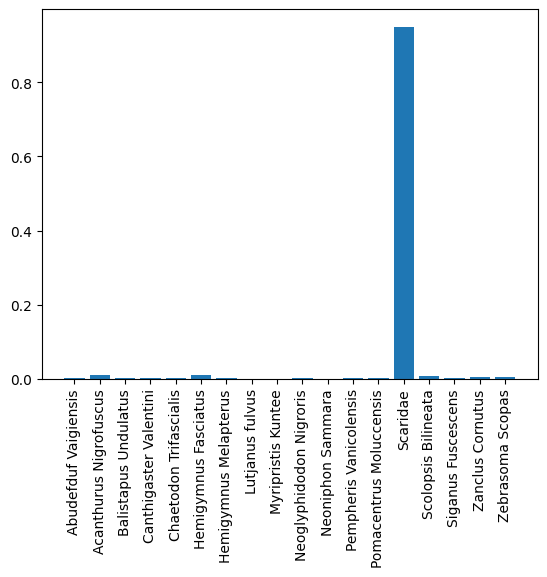

Predicted Class: Scaridae
Confidence: 95.07%
Inference Time: 0.3401 seconds


In [55]:
class_labels = train_dataset.classes
print(class_labels)


image_path = "./DATASET/TEST_ESRGAN2_UNET/Scaridae/fish_001371000118_01367.png"

random_path = './TESTS/images/LR/fish_000013099594_03543.png'
predicted_class, confidence, prediction_time = predict_image_with_debug(torch_proposed_model, image_path, device, class_labels)

predicted_class_label = predicted_class


print(f"Predicted Class: {predicted_class_label}")
print(f"Confidence: {confidence * 100:.2f}%") 
print(f"Inference Time: {prediction_time:.4f} seconds")


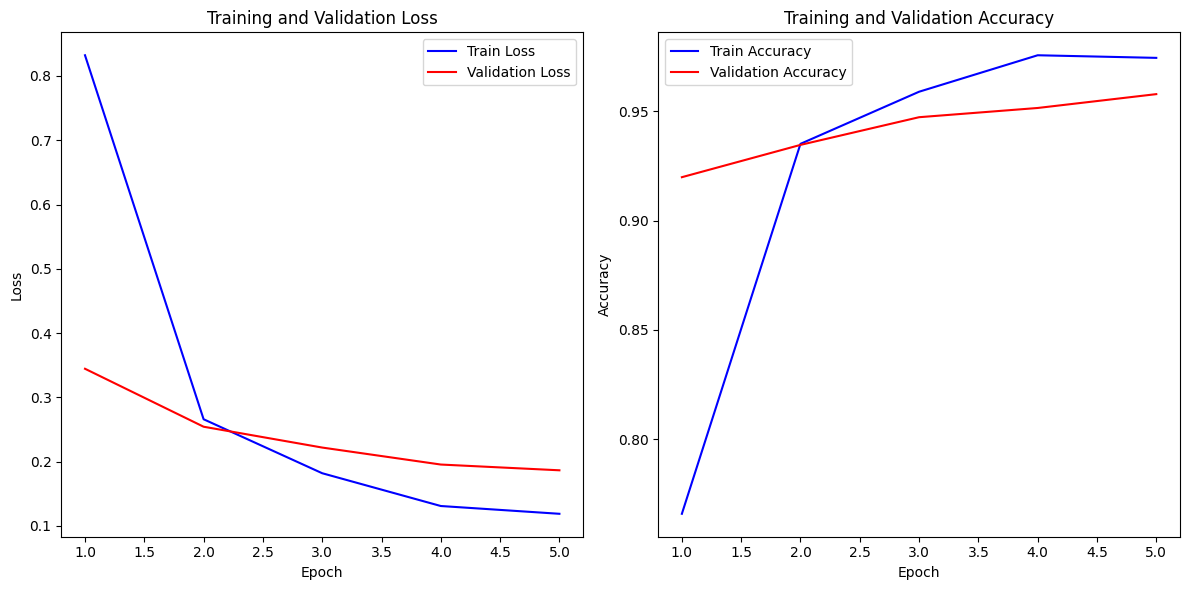

In [56]:
plot_from_history(proposed_history)

In [ ]:
history_df = pd.read_csv('./saved_models/history/torch_history_proposedwithUNETb32notauglr001enhancedvallacc95testacc95traintime3m2sepoch5ratio70_20_10LOWOVERFIT.csv')

history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}

plot_from_history(history)

**SAVE MODEL: MAKE FILENAME MEANINGFUL**

In [57]:

df = pd.DataFrame(proposed_history)
# HISTORY OR GRAPH
df.to_csv('./saved_models/history/torch_history_proposedwithUNETb32notauglr001enhancedvallacc95testacc95traintime3m2sepoch5ratio70_20_10withBatchNormLOWOVERFIT.csv', index=False)

# MODEL
torch.save(torch_proposed_model, './saved_models/model/torch_proposedwithUNETb32notauglr001enhancedvallacc95testacc95traintime3m2sepoch5ratio70_20_10withBatchNormLOWOVERFIT.pth')

# WEIGHTS
torch.save(torch_proposed_model.state_dict(), './saved_models/weights/torch_weights_proposedwithUNETb32notauglr001enhancedvallacc95testacc95traintime3m2sepoch5ratio70_20_10withBatchNormLOWOVERFIT.pth')

# ESRGAN

**RUN IF ENHANCEMENT SUDDENLY STOPPED**

In [3]:

input_folder = './DATASET/TRAIN'
output_folder = './DATASET/TRAIN_ESRGAN3'

os.makedirs(output_folder, exist_ok=True)

found = False


target_file = 'fish_000013609594_03546.png' 
target_folder = 'Lutjanus fulvus' 

for class_name in os.listdir(input_folder):


    if class_name == target_folder:

        class_path = os.path.join(input_folder, class_name)

        if os.path.isdir(class_path):
            enhanced_class_path = os.path.join(output_folder, class_name)
            os.makedirs(enhanced_class_path, exist_ok=True)

            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                

                if not found:
                    if image_file == target_file:
                        found = True 
                        continue
                    else:
                        print(f"Skipping file: {image_file}")
                        continue  

                if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):  
                    print(f"Processing {image_file}...")
                    original, enhance_image_result = enhance_image(image_path, esrgan_model, device)
                    print(f"FINISHED {image_file}: ")
                    # save_image_esrgan(enhance_image_result, os.path.join(enhanced_class_path), device, image_file.split('.')[0])



print("Image enhancement complete. Enhanced images saved in:", output_folder)

Skipping file: fish_000000819594_03402.png
Skipping file: fish_000000819594_03404.png
Skipping file: fish_000000819594_03405.png
Skipping file: fish_000000819594_03406.png
Skipping file: fish_000000819594_03409.png
Skipping file: fish_000000819594_03411.png
Skipping file: fish_000000819594_03412.png
Skipping file: fish_000000819594_03413.png
Skipping file: fish_000000819594_03415.png
Skipping file: fish_000000819594_03417.png
Skipping file: fish_000000819594_03419.png
Skipping file: fish_000000819594_03420.png
Skipping file: fish_000000819594_03421.png
Skipping file: fish_000000819594_03423.png
Skipping file: fish_000000819594_03424.png
Skipping file: fish_000000819594_03425.png
Skipping file: fish_000000819594_03426.png
Skipping file: fish_000000819594_03427.png
Skipping file: fish_000000819594_03428.png
Skipping file: fish_000000819594_03432.png
Skipping file: fish_000004939594_03461.png
Skipping file: fish_000004939594_03462.png
Skipping file: fish_000004939594_03463.png
Skipping fi

**ONLY RUN UNFINISHED FOLDERS**

In [17]:

input_folder = './DATASET/TEST'
output_folder = './DATASET/TEST_ESRGAN3'

os.makedirs(output_folder, exist_ok=True)

# finished_folders = ['Acanthurus Nigrofuscus', 'Canthigaster Valentini', 'Chaetodon Trifascialis',
#                     'Hemigymnus Fasciatus', 'Neoniphon Sammara', 'Pomacentrus Moluccensis',
#                     'Myripristis Kuntee', 'Lutjanus fulvus'
#                     ,'Abudefduf Vaigiensis', 'Balistapus Undulatus', 'Hemigymnus Melapterus', 'Neoglyphidodon Nigroris', 'Pempheris Vanicolensis'] #new added 10 species

finished_folders = ['Acanthurus Nigrofuscus','Abudefduf Vaigiensis','Balistapus Undulatus', 'Canthigaster Valentini', 
                    'Chaetodon Trifascialis', 'Hemigymnus Fasciatus', 'Hemigymnus Melapterus', 'Lutjanus fulvus',
                    ] #new added 10 species

for class_name in os.listdir(input_folder):

    # if class_name in finished_folders:
    #     continue 

    class_path = os.path.join(input_folder, class_name)

    if os.path.isdir(class_path):
        enhanced_class_path = os.path.join(output_folder, class_name)
        os.makedirs(enhanced_class_path, exist_ok=True)

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                
                print(f"Processing {image_file}...")
                original, enhance_image_result = enhance_image(image_path, esrgan_model, device)
                print(f"FINISHED {image_file}: ")
                # save_image_esrgan(enhance_image_result, os.path.join(enhanced_class_path), device, image_file.split('.')[0])

print("Image enhancement complete. Enhanced images saved in:", output_folder)

Processing fish_000011519592_03440.png...
FINISHED fish_000011519592_03440.png: 
Shape before save: (224, 224, 3)
Saved fish_000011519592_03440 at ./DATASET/TEST_ESRGAN3\Abudefduf Vaigiensis
Processing fish_000011519592_03442.png...
FINISHED fish_000011519592_03442.png: 
Shape before save: (224, 224, 3)
Saved fish_000011519592_03442 at ./DATASET/TEST_ESRGAN3\Abudefduf Vaigiensis
Processing fish_000011519592_03445.png...
FINISHED fish_000011519592_03445.png: 
Shape before save: (224, 224, 3)
Saved fish_000011519592_03445 at ./DATASET/TEST_ESRGAN3\Abudefduf Vaigiensis
Processing fish_000064639598_06211.png...
FINISHED fish_000064639598_06211.png: 
Shape before save: (224, 224, 3)
Saved fish_000064639598_06211 at ./DATASET/TEST_ESRGAN3\Abudefduf Vaigiensis
Processing fish_003389205223_25941.png...
FINISHED fish_003389205223_25941.png: 
Shape before save: (224, 224, 3)
Saved fish_003389205223_25941 at ./DATASET/TEST_ESRGAN3\Abudefduf Vaigiensis
Processing fish_003427675288_17827.png...
FIN

KeyboardInterrupt: 

**IMAGE COMPARISONS**

(1, 76, 108, 3)
(224, 224, 3)


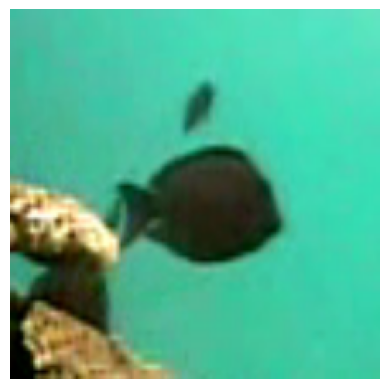

In [140]:
image = preprocess_image('./DATASET/TEST/Acanthurus Nigrofuscus/fish_000026610001_02661.png')

# image = pad_to_square(tf.squeeze(image))
print(image.shape)
image = tf.image.resize(tf.squeeze(image), (224, 224))
print(image.shape)
plot_image_tensor(tf.squeeze(image))

(1, 224, 224, 3)
(224, 224, 3)


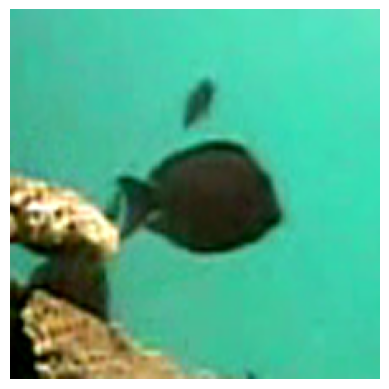

In [141]:
image = preprocess_image('./DATASET/TEST_ESRGAN2/Acanthurus Nigrofuscus/fish_000026610001_02661.png')

# image = pad_to_square(tf.squeeze(image))
print(image.shape)
image = tf.squeeze(image)
# image = tf.image.resize(tf.squeeze(image), (224, 224))
print(image.shape)
plot_image_tensor(image)

# U-NET TESTING AND TRAINING

**WITH ENHANCED IMAGES DATASET**

In [3]:

# Constants
SIZE_X, SIZE_Y = 224, 224
BATCH_SIZE = 16  # Adjust as needed

# Define Transformations (for normalization)
image_transform = transforms.Compose([
    # transforms.Resize((SIZE_X, SIZE_Y)),
    transforms.ToTensor(),  # Convert to tensor (H, W, C) -> (C, H, W)
    transforms.Normalize([0.485, 0.456, 0.406], [.229, .224, .225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((SIZE_X, SIZE_Y)),
    transforms.ToTensor(),  # Convert mask to tensor
])

# Dataset Paths
image_dir = "./DATASET/TRAIN_UNET/enhanced_images2"
mask_dir = "./DATASET/TRAIN_UNET/mask"

# Get sorted list of images and masks
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

assert len(image_paths) == len(mask_paths), "Mismatch in image-mask pairs!"

# Split Dataset (80% train, 10% val, 10% test)
total_size = len(image_paths)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Ensure full dataset is used

train_paths, val_paths, test_paths = image_paths[:train_size], image_paths[train_size:train_size+val_size], image_paths[train_size+val_size:]
train_masks, val_masks, test_masks = mask_paths[:train_size], mask_paths[train_size:train_size+val_size], mask_paths[train_size+val_size:]

# Helper function to load and preprocess images and masks on demand
def load_image(image_path):
    image = cv2.imread(image_path, 1)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image = Image.fromarray(image)  
    image = image_transform(image)  
    return image

def load_mask(mask_path):
    mask = cv2.imread(mask_path, 0)  # Read mask as grayscale (NumPy array)
    mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image
    mask = mask_transform(mask)  # Apply transformations
    return mask

# DataLoader for train, validation, and test
def create_dataloader(image_paths, mask_paths, batch_size):
    # Use zip to load images and masks and return a DataLoader
    dataset = [(load_image(img_path), load_mask(mask_path)) for img_path, mask_path in zip(image_paths, mask_paths)]
    
    # Convert to DataLoader
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

# Create DataLoaders
train_loader = create_dataloader(train_paths, train_masks, BATCH_SIZE)
val_loader = create_dataloader(val_paths, val_masks, BATCH_SIZE)
test_loader = create_dataloader(test_paths, test_masks, BATCH_SIZE)

# Print dataset sizes
print(f"Total dataset size: {total_size}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")


Total dataset size: 2399
Training set size: 1919
Validation set size: 239
Test set size: 241


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.8745097923278808].


Image shape: (224, 224, 3)
Mask shape: (224, 224)


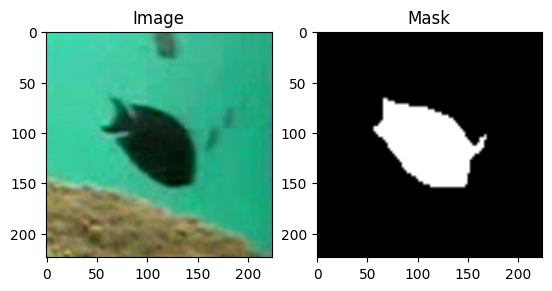

In [4]:
def show_sample(loader):
    # Get a batch of images and masks
    batch = next(iter(loader))
    
    # Access the image and mask tensors from the batch
    images, masks = batch  # Unpack the tuple
    
    # Get the first image and mask from the batch
    image = images[0].numpy().transpose(1, 2, 0)  # Convert from CHW to HWC
    mask = masks[0].squeeze().numpy()  # Remove the single channel and convert to numpy

    # Reverse normalization to bring image back to [0, 1] range for display
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Reverse normalization

    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    
    # Plot image and mask
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # Mask is a single channel image, so use gray colormap
    plt.title("Mask")
    
    plt.show()

# Display sample from training, validation, and test sets
show_sample(train_loader)


# TRAIN

**TRAINING**

In [4]:
focal_loss = smp.losses.FocalLoss(mode='binary', alpha=0.25, gamma=2)
dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1e-6)
epochs = 10
def combined_loss(outputs, labels):
    return dice_loss(outputs, labels) + focal_loss(outputs, labels)

model = smp.Unet(
    encoder_name="resnet34",       
    encoder_weights="imagenet",    
    in_channels=3,                  
    classes=1,
    activation='sigmoid'                     
)

# model.eval()

optimizer = torch.optim.Adam(model.parameters(), lr=.0001)  

# Train the model
history = train_model_unet(model.to(device), train_loader, val_loader, optimizer, combined_loss, epochs=epochs, device=device)


Epoch 1/10: 100%|██████████████████████████████████████████████| 120/120 [00:59<00:00,  2.01batch/s]


Epoch 1/10: Train Loss=0.9051, Train IoU=0.8051, Val Loss=0.9032, Val IoU=0.8796


Epoch 2/10: 100%|██████████████████████████████████████████████| 120/120 [00:49<00:00,  2.41batch/s]


Epoch 2/10: Train Loss=0.8692, Train IoU=0.8971, Val Loss=0.8935, Val IoU=0.8970


Epoch 3/10: 100%|██████████████████████████████████████████████| 120/120 [00:49<00:00,  2.41batch/s]


Epoch 3/10: Train Loss=0.8623, Train IoU=0.9068, Val Loss=0.8883, Val IoU=0.9085


Epoch 4/10: 100%|██████████████████████████████████████████████| 120/120 [00:49<00:00,  2.41batch/s]


Epoch 4/10: Train Loss=0.8587, Train IoU=0.9125, Val Loss=0.8864, Val IoU=0.8996


Epoch 5/10: 100%|██████████████████████████████████████████████| 120/120 [00:49<00:00,  2.41batch/s]


Epoch 5/10: Train Loss=0.8567, Train IoU=0.9160, Val Loss=0.8850, Val IoU=0.9085


Epoch 6/10: 100%|██████████████████████████████████████████████| 120/120 [00:49<00:00,  2.41batch/s]


Epoch 6/10: Train Loss=0.8553, Train IoU=0.9189, Val Loss=0.8839, Val IoU=0.9095


Epoch 7/10: 100%|██████████████████████████████████████████████| 120/120 [00:49<00:00,  2.40batch/s]


Epoch 7/10: Train Loss=0.8543, Train IoU=0.9209, Val Loss=0.8834, Val IoU=0.9063


Epoch 8/10: 100%|██████████████████████████████████████████████| 120/120 [00:49<00:00,  2.40batch/s]


Epoch 8/10: Train Loss=0.8536, Train IoU=0.9226, Val Loss=0.8830, Val IoU=0.9144


Epoch 9/10: 100%|██████████████████████████████████████████████| 120/120 [00:49<00:00,  2.41batch/s]


Epoch 9/10: Train Loss=0.8530, Train IoU=0.9240, Val Loss=0.8825, Val IoU=0.9057


Epoch 10/10: 100%|█████████████████████████████████████████████| 120/120 [00:49<00:00,  2.41batch/s]


Epoch 10/10: Train Loss=0.8525, Train IoU=0.9256, Val Loss=0.8827, Val IoU=0.9143


In [3]:
def save_model(model, history, model_path, history_path):
    # Save the model state dict
    torch.save(model, model_path)

    save_history_to_csv(history, history_path)

    print(f"Model saved to {model_path}")
    print(f"History saved to {history_path}")

# Loading the entire model

def save_history_to_csv(history, filename):
    df = pd.DataFrame(history)
    df.to_csv(filename, index=False)
    print(f"History saved to {filename}")

def load_entire_model(model_path, device):
    # Load the entire model
    model = torch.load(model_path, weights_only=False)
    model.to(device)  # Ensure the model is on the correct device (CPU or GPU)
    print(f"Model loaded from {model_path}")
    
    return model

def plot_history(df):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train_loss'], label='Training Loss', color='blue')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot IoU
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['train_iou'], label='Training IoU', color='blue')
    plt.plot(df['epoch'], df['val_iou'], label='Validation IoU', color='orange')
    plt.title('IoU Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

def load_history_from_csv(filename):
    df = pd.read_csv(filename)
    return df



In [6]:
save_model(model, history, './saved_models/unet_model224.pth', './saved_models/unet_history224.csv')

History saved to ./saved_models/unet_history224.csv
Model saved to ./saved_models/unet_model224.pth
History saved to ./saved_models/unet_history224.csv


In [6]:
model = load_entire_model('./saved_models/unet_model224.pth', device)

Model loaded from ./saved_models/unet_model224.pth


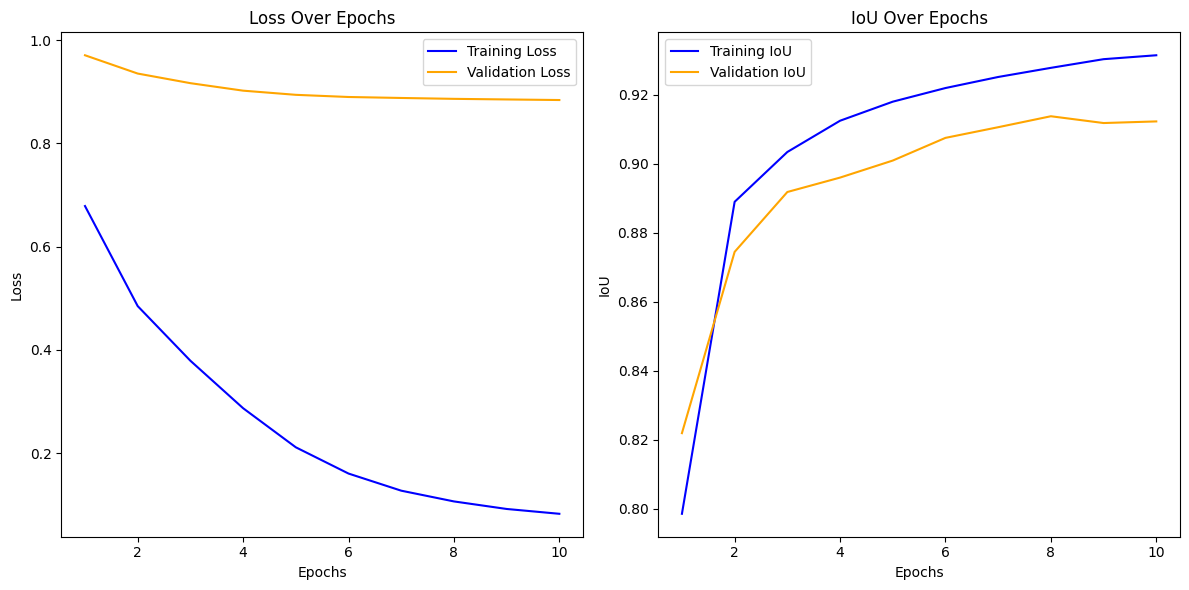

In [8]:
loaded_history = load_history_from_csv('./saved_models/unet_history.csv')
plot_history(loaded_history)

# TEST U NET

In [19]:

SIZE_X, SIZE_Y = 224, 224

# Define paths for input and output directories
input_dirs = {"test": "./DATASET/VALIDATION_ESRGAN2"}
output_dirs = {"test": "./DATASET/VALIDATION_ESRGAN2_UNET"}
mask_dir = './DATASET/TRAIN_UNET/mask'

# Create output directories if they don't exist
for split, output_dir in output_dirs.items():
    os.makedirs(output_dir, exist_ok=True)
    for species in os.listdir(input_dirs[split]):
        os.makedirs(os.path.join(output_dir, species), exist_ok=True)

# Parameters
threshold = 0.3  # Threshold for binary mask

def get_corresponding_mask(image_filename):
    fishnumber = image_filename.split('_')[1] + '_' + image_filename.split('_')[2].split('.')[0]
    mask_filename = f"mask_{fishnumber}.png"
    mask_path = os.path.join(mask_dir, mask_filename)
    if os.path.exists(mask_path):
        return mask_path
    else:
        print(f"Mask not found for: {mask_filename}")
        return None


def preprocess_image(image_path):
    # Read the image
    img = Image.open(image_path).convert('RGB')
    
    # Define the transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Adjust if needed
    ])
    
    img = transform(img)
    return img

def process_all(model, device):
    # Process the test set and display images at each step
    for split, input_dir in input_dirs.items():
        output_dir = output_dirs[split]

        for species in os.listdir(input_dir):
            species_dir = os.path.join(input_dir, species)
            output_species_dir = os.path.join(output_dir, species)

            display_count = 0

            for img_name in os.listdir(species_dir):
                # if display_count >= 5:  # Stop plotting after 5 images
                #     break
                print('Image name:', img_name)
                # Load and preprocess the image
                img_path = os.path.join(species_dir, img_name)

                image = preprocess_image(img_path)
                image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

                # Load the ground truth mask (Assuming ground truth masks are stored in a 'masks' folder)
                ground_truth_path = get_corresponding_mask(img_name)
                print(ground_truth_path)
                ground_truth_mask = cv2.imread(ground_truth_path, 0)
                ground_truth_mask = cv2.resize(ground_truth_mask, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_CUBIC)

                # Run the model on the image
                with torch.no_grad():  # No need to compute gradients for inference
                    model.eval()  # Set the model to evaluation mode
                    predicted_mask = model(image)


                # Convert predicted mask to numpy array and apply threshold
                predicted_mask = predicted_mask.squeeze().cpu().numpy()
                binary_mask = (predicted_mask > threshold).astype(np.uint8)
                image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  
                # Apply the binary mask to the image
                masked_image_pred = image * np.expand_dims(binary_mask, axis=-1)
                masked_image_pred = (masked_image_pred * 255).astype(np.uint8)

                # Display images to inspect each step
                # fig, ax = plt.subplots(1, 4, figsize=(16, 8))
                # ax[0].imshow(image)  
                # ax[0].set_title("Original Image")
                # ax[0].axis('off')

                # ax[1].imshow(ground_truth_mask, cmap='gray')
                # ax[1].set_title("Ground Truth Mask")
                # ax[1].axis('off')

                # ax[2].imshow(binary_mask, cmap='gray')
                # ax[2].set_title("Predicted Binary Mask (Threshold Applied)")
                # ax[2].axis('off')

                # ax[3].imshow(masked_image_pred)
                # ax[3].set_title("Final Masked Image")
                # ax[3].axis('off')

                # plt.tight_layout()
                # plt.show()

                display_count += 1
                print("masked iamge shape: ", masked_image_pred.shape)
                output_path = os.path.join(output_species_dir, img_name)
                cv2.imwrite(output_path, cv2.cvtColor(masked_image_pred, cv2.COLOR_RGB2BGR))


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

process_all(model.to(device), device)


Image name: fish_000001719594_03398.png
./DATASET/TRAIN_UNET/mask\mask_000001719594_03398.png
masked iamge shape:  (224, 224, 3)
Image name: fish_000003709594_03460.png
./DATASET/TRAIN_UNET/mask\mask_000003709594_03460.png
masked iamge shape:  (224, 224, 3)
Image name: fish_000005829592_03459.png
./DATASET/TRAIN_UNET/mask\mask_000005829592_03459.png
masked iamge shape:  (224, 224, 3)
Image name: fish_000005949592_03449.png
./DATASET/TRAIN_UNET/mask\mask_000005949592_03449.png
masked iamge shape:  (224, 224, 3)
Image name: fish_000005949592_03454.png
./DATASET/TRAIN_UNET/mask\mask_000005949592_03454.png
masked iamge shape:  (224, 224, 3)
Image name: fish_000007369595_03644.png
./DATASET/TRAIN_UNET/mask\mask_000007369595_03644.png
masked iamge shape:  (224, 224, 3)
Image name: fish_000011109595_03645.png
./DATASET/TRAIN_UNET/mask\mask_000011109595_03645.png
masked iamge shape:  (224, 224, 3)
Image name: fish_000011519592_03436.png
./DATASET/TRAIN_UNET/mask\mask_000011519592_03436.png
mas

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 0.5]))
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]